In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qutip import *
from tcn import TCN, tcn_full_summary
from tqdm import tqdm
import time

from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Dense
from keras.models import Model
import seaborn as sns

from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score,r2_score
from keras.losses import Huber
import keras.backend as K

from utilis import QuCal, pre_processing, plot_losses
from model import TCN_autoencoder

2025-01-27 05:03:53.131228: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 05:03:53.271394: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
Y = np.load('../dataset/Data_Y.npy', allow_pickle=True)
Y.shape

(3700, 512, 1)

lowest frequency for the data:  4.260000000000001
number of frewuencies: 3700


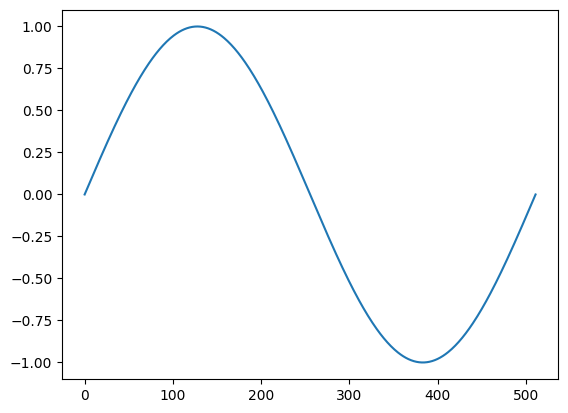

In [3]:
full_ω, t, E = QuCal()

100%|███████████████████████████████████| 3700/3700 [00:00<00:00, 176855.86it/s]

omega values for input data:  (3700,)
x data : (3700, 512)


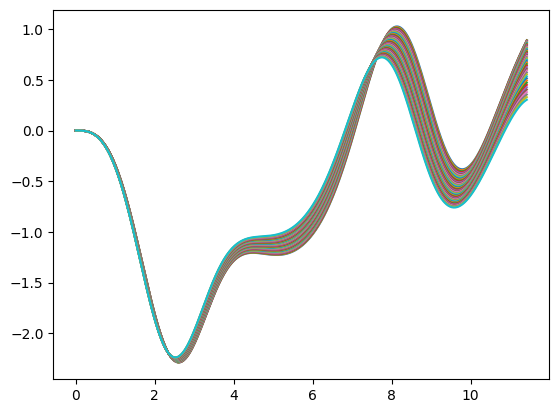

scaled_X_train:  (2960, 512, 1)
scaled_y_train:  (2960, 512, 1)
scaled_X_test:  (740, 512, 1)
scaled_y_test:  (740, 512, 1)
scaled_X_train max:  1.0
scaled_X_train min:  3.661721e-11
scaled_y_train max:  1.0
scaled_y_train min :  0.0


In [ ]:
scaled_X_train, scaled_y_train,scaled_X_test,scaled_y_test, omega_y_test = pre_processing(Y , full_ω,t, F0 = 1 )

In [5]:

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
def swish_activation(x, beta=1.2):
    return x * K.sigmoid(beta * x)

def Autoencoder(input_size = 512, f1 = 5,f2 = 5,lf = 3,CNN_out = True):
    
    # Encoder
    input_data = Input(shape=(input_size, 1))  # Assuming one channel for simplicity
    encoded = Conv1D(5, kernel_size=3, activation=swish_activation, padding='same')(input_data)
    encoded = MaxPooling1D(pool_size=2)(encoded)
    encoded = Conv1D(5, kernel_size=3, activation=swish_activation, padding='same')(encoded)
    encoded = MaxPooling1D(pool_size=2)(encoded)

    
    # bottle neck
    encoded = Conv1D(3, kernel_size=3, activation=swish_activation, padding='same')(encoded)

    # Decoder
    decoded = Conv1D(5, kernel_size=3, activation=swish_activation, padding='same')(encoded)
    decoded = UpSampling1D(size=2)(decoded)
    decoded = Conv1D(5, kernel_size=3, activation=swish_activation, padding='same')(decoded)
    decoded = UpSampling1D(size=2)(decoded)
    if CNN_out:
        decoded = Conv1D(1, kernel_size=3, activation=swish_activation, padding='same')(decoded)
    else:
        decoded = Dense(1)(decoded)
    # Autoencoder model
    autoencoder = Model(input_data, decoded)
    return autoencoder

with mirrored_strategy.scope():
    

    CNN_AE = Autoencoder(input_size=512,f1 = 5,f2 = 5, lf = 3,CNN_out = True)
    #Compile the model
    CNN_AE.compile(optimizer=Adam(learning_rate = 0.001), loss=Huber(delta=1.0), metrics=['accuracy'])



#Define a callback to save the best model
checkpoint_filepath = 'outputs/best_1d_cnn_model_v1_bkp.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

#Display the model architecture
CNN_AE.summary()

2025-01-27 05:04:05.368929: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-27 05:04:05.849653: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46614 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2025-01-27 05:04:05.850393: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46614 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:1e:00.0, compute capability: 8.6
2025-01-27 05:04:05.850938: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1621] Created device /job:localhost/replica:0/task:0/

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 512, 5)            20        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 256, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 256, 5)            80        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 128, 5)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 128, 3)            48    

Epoch 1/50


2025-01-27 05:04:11.202526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801


24/24 [==============================] - ETA: 0s - loss: 0.1196 - accuracy: 6.5984e-07
Epoch 1: val_loss improved from inf to 0.10141, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
24/24 [==============================] - 7s 93ms/step - loss: 0.1196 - accuracy: 6.5984e-07 - val_loss: 0.1014 - val_accuracy: 0.0000e+00
Epoch 2/50
24/24 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 6.5984e-07
Epoch 2: val_loss improved from 0.10141 to 0.03956, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
24/24 [==============================] - 1s 30ms/step - loss: 0.0759 - accuracy: 6.5984e-07 - val_loss: 0.0396 - val_accuracy: 0.0000e+00
Epoch 3/50
22/24 [==========================>...] - ETA: 0s - loss: 0.0342 - accuracy: 1.3872e-06
Epoch 3: val_loss improved from 0.03956 to 0.03081, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
24/24 [==============================] - 1s 26ms/step - loss: 0.0341 - accuracy: 1.3197e-06 - val_loss: 0.0308 - val_accuracy: 0.0000

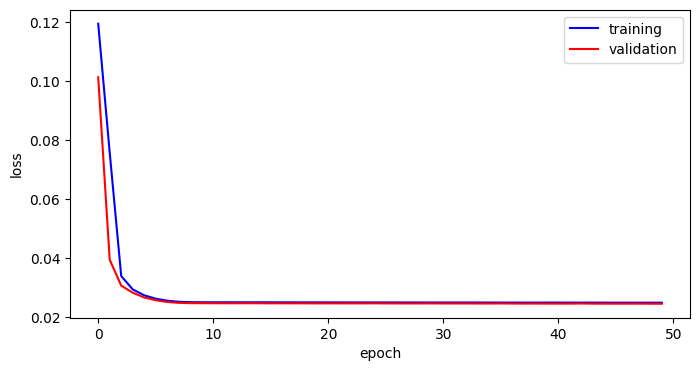

Epoch 1/50
46/47 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 6.6343e-07
Epoch 1: val_loss improved from 0.02466 to 0.02465, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
47/47 [==============================] - 1s 25ms/step - loss: 0.0250 - accuracy: 6.5984e-07 - val_loss: 0.0247 - val_accuracy: 0.0000e+00
Epoch 2/50
46/47 [============================>.] - ETA: 0s - loss: 0.0250 - accuracy: 6.6343e-07
Epoch 2: val_loss improved from 0.02465 to 0.02464, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
47/47 [==============================] - 1s 23ms/step - loss: 0.0250 - accuracy: 6.5984e-07 - val_loss: 0.0246 - val_accuracy: 0.0000e+00
Epoch 3/50
46/47 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 6.6343e-07
Epoch 3: val_loss did not improve from 0.02464
47/47 [==============================] - 1s 21ms/step - loss: 0.0250 - accuracy: 6.5984e-07 - val_loss: 0.0247 - val_accuracy: 0.0000e+00
Epoch 4/50
46/47 [===================

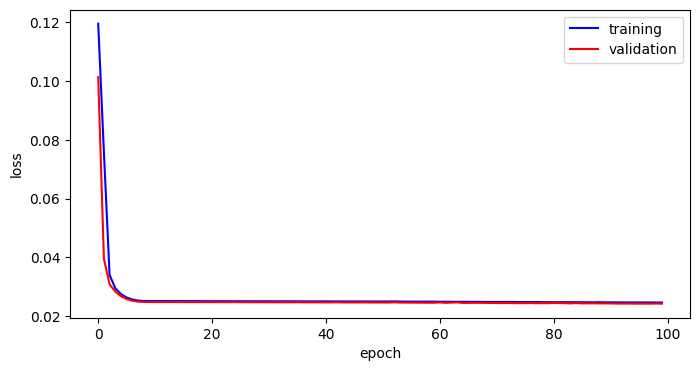

Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 0.0247 - accuracy: 6.5984e-07
Epoch 1: val_loss did not improve from 0.02425
93/93 [==============================] - 2s 22ms/step - loss: 0.0247 - accuracy: 6.5984e-07 - val_loss: 0.0245 - val_accuracy: 0.0000e+00
Epoch 2/50
91/93 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 6.7072e-07
Epoch 2: val_loss did not improve from 0.02425
93/93 [==============================] - 2s 21ms/step - loss: 0.0247 - accuracy: 6.5984e-07 - val_loss: 0.0243 - val_accuracy: 0.0000e+00
Epoch 3/50
91/93 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 6.7072e-07
Epoch 3: val_loss improved from 0.02425 to 0.02421, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
93/93 [==============================] - 2s 21ms/step - loss: 0.0247 - accuracy: 6.5984e-07 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 4/50
92/93 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 6.6343e

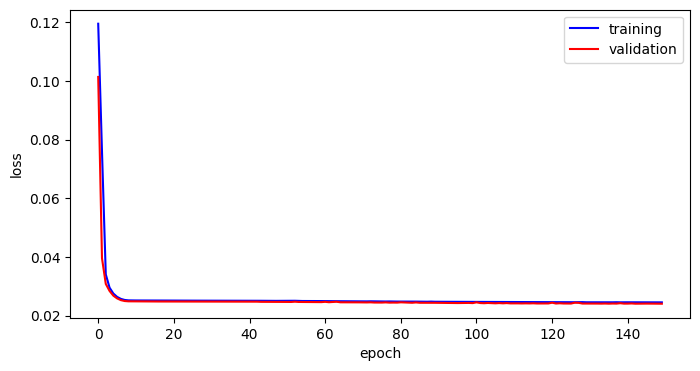

Epoch 1/50
184/185 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 6.6343e-07
Epoch 1: val_loss did not improve from 0.02404
185/185 [==============================] - 4s 21ms/step - loss: 0.0245 - accuracy: 6.5984e-07 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 2/50
184/185 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 1.3269e-06
Epoch 2: val_loss did not improve from 0.02404
185/185 [==============================] - 4s 20ms/step - loss: 0.0245 - accuracy: 1.3197e-06 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 3/50
185/185 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 1.3197e-06
Epoch 3: val_loss did not improve from 0.02404
185/185 [==============================] - 4s 20ms/step - loss: 0.0245 - accuracy: 1.3197e-06 - val_loss: 0.0241 - val_accuracy: 0.0000e+00
Epoch 4/50
184/185 [============================>.] - ETA: 0s - loss: 0.0245 - accuracy: 6.6343e-07
Epoch 4: val_loss did not improve from 

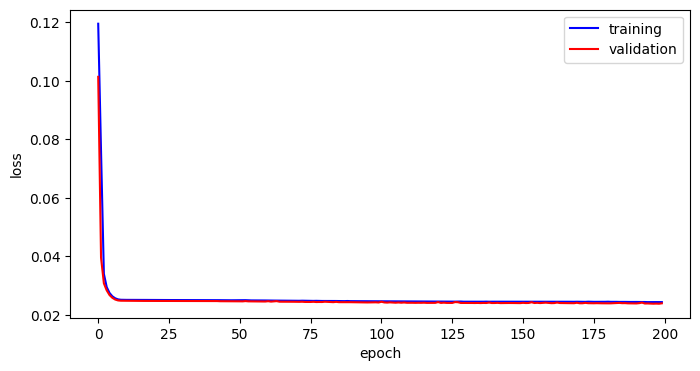

Epoch 1/50
368/370 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 1.3269e-06
Epoch 1: val_loss did not improve from 0.02383
370/370 [==============================] - 8s 20ms/step - loss: 0.0244 - accuracy: 1.3197e-06 - val_loss: 0.0240 - val_accuracy: 0.0000e+00
Epoch 2/50
368/370 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 1.3269e-06
Epoch 2: val_loss improved from 0.02383 to 0.02374, saving model to outputs/best_1d_cnn_model_v1_bkp.h5
370/370 [==============================] - 7s 20ms/step - loss: 0.0244 - accuracy: 1.3197e-06 - val_loss: 0.0237 - val_accuracy: 0.0000e+00
Epoch 3/50
370/370 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 6.5984e-07
Epoch 3: val_loss did not improve from 0.02374
370/370 [==============================] - 7s 20ms/step - loss: 0.0244 - accuracy: 6.5984e-07 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 4/50
370/370 [==============================] - ETA: 0s - loss: 0.0243 - acc

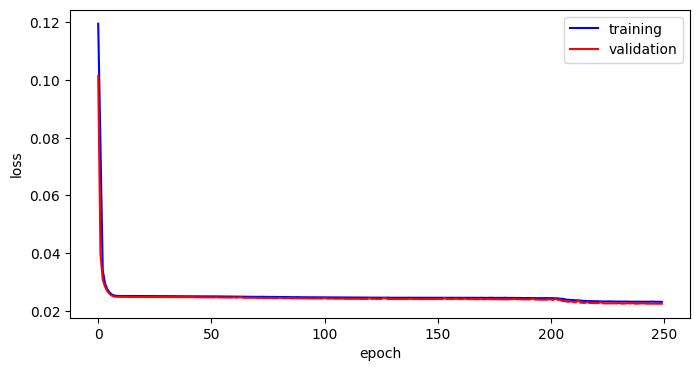

Execution time 747.6524 seconds


In [6]:
# ##### Train the model
tic = time.perf_counter()
for n in ([7,6,5,4,3]):  
    # training in a cycle with increasing batch size  . IF i increase the size to 10 from 7 then the train process just stops after 5th cycle and this is because of the GPU memory issue.

    batch_size = 2**n  
    
    history = CNN_AE.fit(scaled_X_train, scaled_y_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=(scaled_X_test, scaled_y_test),callbacks=[model_checkpoint_callback])
    
    loss_save = history.history['loss']
    val_loss_save = history.history['val_loss']
    if n in ([6,5,4,3]):
        
        loss_sum = np.concatenate((loss_sum, loss_save), axis = 0)
        val_loss_sum = np.concatenate((val_loss_sum, val_loss_save), axis = 0)
    else:
   
        loss_sum = loss_save
        val_loss_sum = val_loss_save  

    plot_losses(loss_sum,val_loss_sum)

toc = time.perf_counter()
print(f"Execution time {toc - tic:0.4f} seconds")



24/24 [==============================] - 1s 6ms/step
(740, 512, 1)


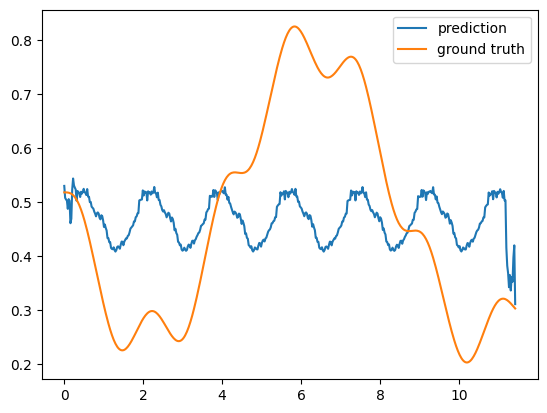

In [7]:
#Compute predicted values
prediction_test = CNN_AE.predict(scaled_X_test)
print(prediction_test.shape)


# # Create a StandardScaler object


plt.plot(t,prediction_test[50],label = 'prediction')
plt.plot(t,scaled_y_test[50], label = 'ground truth')
plt.legend()
plt.show()

In [8]:
r2_test = r2_score(scaled_y_test.reshape(-1), prediction_test.reshape(-1))
print(r2_test)

r2_test_set = [r2_score(scaled_y_test[i].reshape(-1), prediction_test[i].reshape(-1)) for i in range(len(scaled_y_test))]
print(len(r2_test_set))

0.10174946598401757
740


In [9]:

above = np.sum(np.array(r2_test_set) > 0.90)/740 * 100
print('$R^{2}$ above 90 :',above)

above1 = np.sum(np.array(r2_test_set) > 0.95)/740 * 100
print('$R^{2}$ above 95 :',above1)

$R^{2}$ above 90 : 0.0
$R^{2}$ above 95 : 0.0


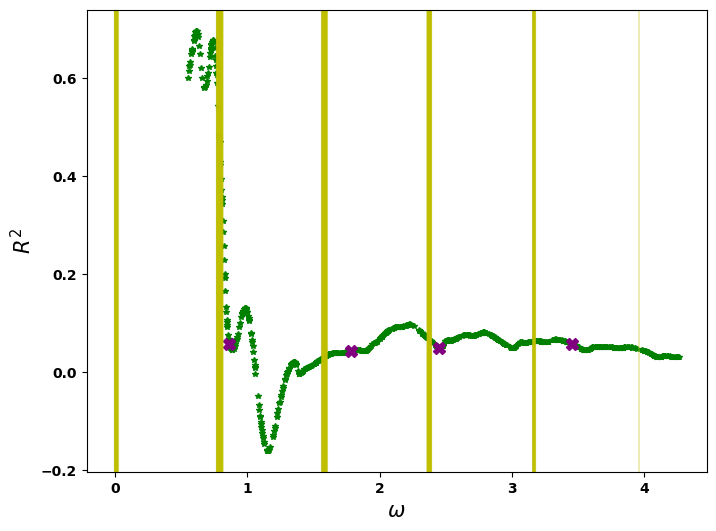

In [12]:
plt.figure(figsize=(8, 6))  # Adjust the width and height as needed


plt.plot(omega_y_test, r2_test_set, '*', markersize=4, color='g')
# plt.plot(ω_test, r2_test_set, '.', color='red')
# Plot highlighted points in red

for i in [2, 100, 250, 600]:
    plt.plot(omega_y_test[i], r2_test_set[i], 'X',markersize=9, color='purple')


for _ in np.unique(np.round(np.abs(E[:, np.newaxis] - E), 4)):
    plt.axvline(_, c='y', alpha=0.3)
# plt.axhline(r2_test, color='blue', linestyle='--')  # Plot the horizontal line for r2_test
# plt.text(0.14, r2_test, f"Avg. $R^{2}$ = {r2_test:.4}", color='blue',fontsize=12,weight='bold', va='bottom', ha='left')  # Display the value of r2_test on the plot
plt.xlabel(r"$\omega$",fontsize=15)
plt.ylabel(r"$R^2$",fontsize=15)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
# plt.title("$\omega$ vs. $R^2$ score")
#plt.title("Amplitude = 1", fontsize = 14)
# plt.savefig('R2_Omega_v4_1.png')
plt.savefig('outputs/A1_CNN_v1.pdf', dpi=1000, bbox_inches='tight')
plt.show()

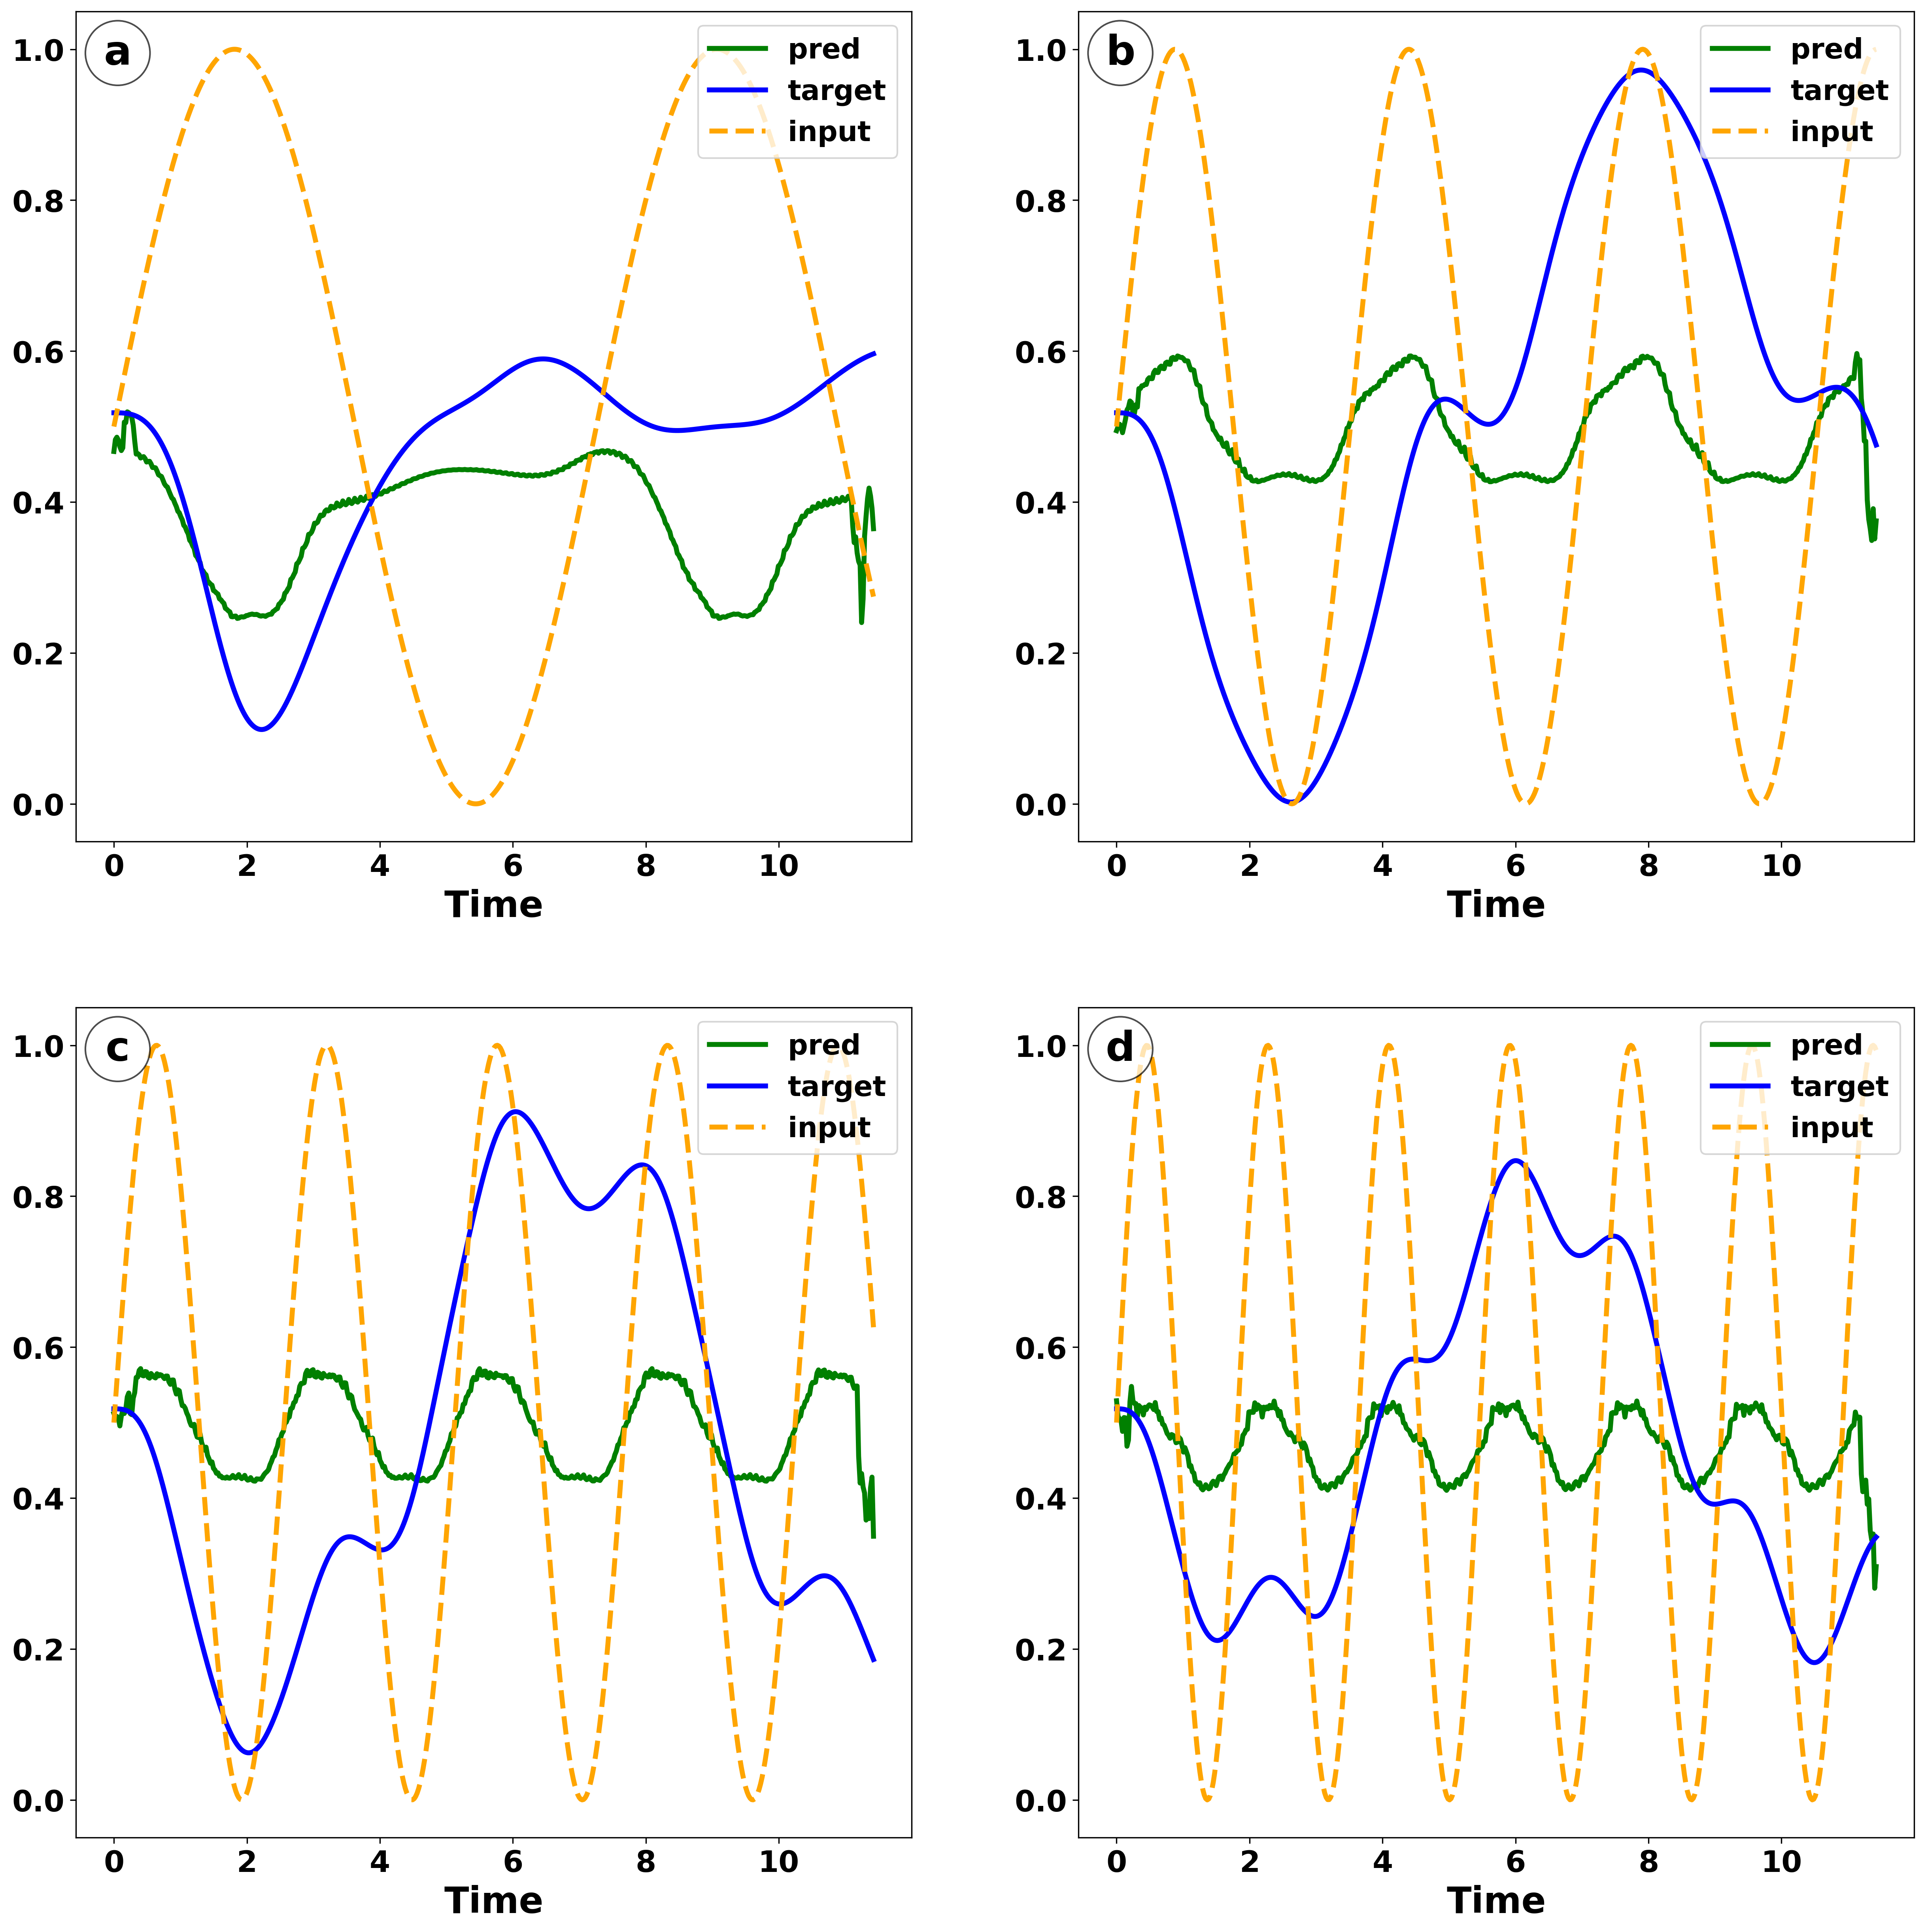

In [11]:

from matplotlib import rcParams

rcParams['font.weight'] = 'bold'
rcParams['font.size'] = 17
labels = ['a', 'b', 'c', 'd']

plt.figure(figsize=(20, 20), dpi=300)
arr =  np.array([2, 100, 250, 600])
j=0
for i in arr:
    plt.subplot(2, 2, j+1)
    plt.plot(t,prediction_test[i, :], label = "pred",color = 'green', linewidth=3)
    plt.plot(t, scaled_y_test[ i, :], label = "target", color = 'blue', linewidth=3  )
    plt.plot( t, scaled_X_test[i, :],'--', label = "input", color = 'orange', linewidth=3 )
    #plt.plot( t, F0 * np.sin(ω_train[i] * t),'--', label = "input",linewidth=4 )
    plt.legend(loc='upper right')
    #plt.title("ω = {}".format(omega_y_test[i]),fontsize=22)
    plt.xlabel("Time",fontsize=22)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
#     plt.ylabel("Expectation Value of Magnetization",  fontsize=27)
    plt.annotate(labels[j], xy=(0.05, 0.95), xycoords='axes fraction', fontsize=25,
                 ha='center', va='center',
                 bbox=dict(boxstyle='circle', fc='w', ec='k', lw=1, alpha=0.7))
    j=j+1

# plt.savefig('outputs/Achaotic25TEST.pdf', dpi=700, bbox_inches='tight')
plt.show()
